In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm

%matplotlib inline

In [2]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sd=1, shape=10)

In [3]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, njobs=2)

100%|██████████| 3000/3000 [00:02<00:00, 1004.39it/s]


In [4]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

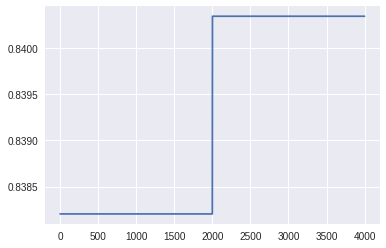

In [5]:
plt.plot(trace['step_size_bar'])

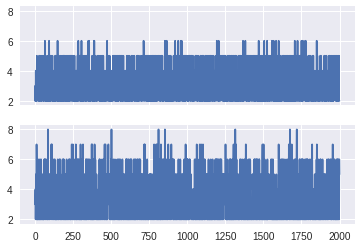

In [6]:
sizes1, sizes2 = trace.get_sampler_stats('depth', combine=False)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(sizes1)
ax2.plot(sizes2)

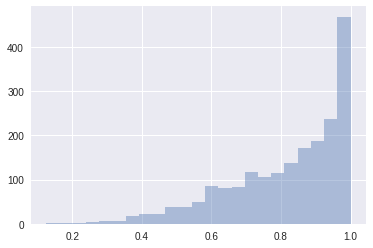

In [7]:
accept = trace.get_sampler_stats('mean_tree_accept', burn=1000)
sb.distplot(accept, kde=False)

In [8]:
accept.mean()

0.81584380805753631

In [9]:
trace['diverging'].nonzero()

(array([], dtype=int64),)

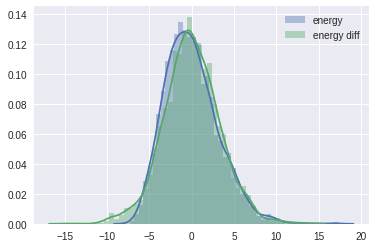

In [10]:
energy = trace['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()

## GLM

In [11]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

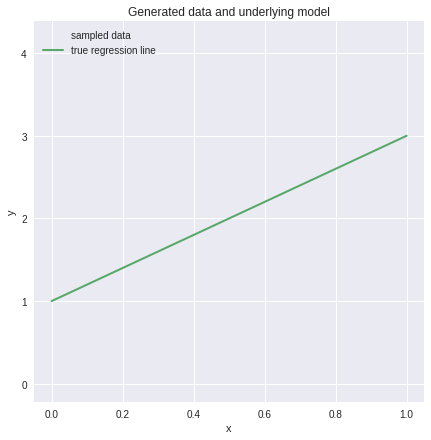

In [16]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [21]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x, sd=sigma, observed=y)

    # Inference!
    trace = pm.sample(3000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3500/3500 [00:03<00:00, 1097.00it/s]


In [24]:
with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(3000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3500/3500 [00:16<00:00, 209.18it/s]
/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.896322706109, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


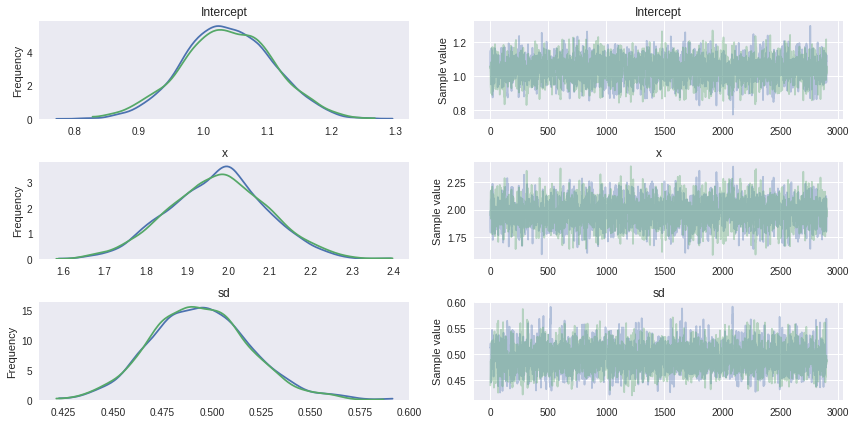

In [26]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

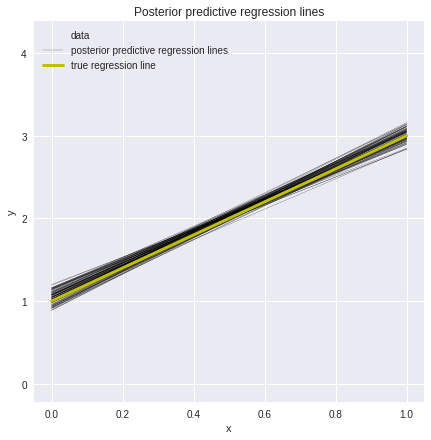

In [28]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');